# Bulk whole lung

In [79]:
# Setup

import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
import glob
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [80]:
#files = glob.glob("/home/sina/projects/mouse_lung/*_bulk/out/abundance.tsv")
files = [
    "/home/sina/projects/mouse_lung/SRR8426373_bulk/out/abundance.tsv",
    "/home/sina/projects/mouse_lung/SRR8426374_bulk/out/abundance.tsv",
    "/home/sina/projects/mouse_lung/SRR8426375_bulk/out/abundance.tsv",
    "/home/sina/projects/mouse_lung/SRR8426376_bulk/out/abundance.tsv",
    "/home/sina/projects/mouse_lung/SRR8426377_bulk/out/abundance.tsv",
    "/home/sina/projects/mouse_lung/SRR8426378_bulk/out/abundance.tsv"
]

In [81]:
files

['/home/sina/projects/mouse_lung/SRR8426373_bulk/out/abundance.tsv',
 '/home/sina/projects/mouse_lung/SRR8426374_bulk/out/abundance.tsv',
 '/home/sina/projects/mouse_lung/SRR8426375_bulk/out/abundance.tsv',
 '/home/sina/projects/mouse_lung/SRR8426376_bulk/out/abundance.tsv',
 '/home/sina/projects/mouse_lung/SRR8426377_bulk/out/abundance.tsv',
 '/home/sina/projects/mouse_lung/SRR8426378_bulk/out/abundance.tsv']

In [82]:
cols = ["target_id","length","eff_length","est_counts","tpm","SRR"]

In [83]:
age_map =  {"SRR8426373": 22,
            "SRR8426374": 22,
            "SRR8426375": 22,
            "SRR8426376": 3,
            "SRR8426377": 3,
            "SRR8426378": 3}

In [84]:
t2g = pd.read_csv("../reference/t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
t2g.index = t2g.tid
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

In [85]:
%%time
data = []
for fn, f in enumerate(files):
    tmp = pd.read_csv(f, sep="\t")
    tmp["SRR"] = f.split("/")[-3].split("_")[0]
    tmp["age"] = tmp["SRR"].map(age_map)
    tmp["gene_name"] = tmp["target_id"].map(t2g["gene_name"])
    data.append(tmp)

CPU times: user 916 ms, sys: 79.8 ms, total: 996 ms
Wall time: 993 ms


In [86]:
df = pd.concat(data, ignore_index=True)

In [87]:
df.to_csv("write/bulk.csv")

# ACE2

In [88]:
ace2 = df[df["gene_name"] == "Ace2"]

In [89]:
tmp = pd.DataFrame(ace2.groupby(["SRR", "gene_name"])["tpm"].sum()).reset_index()
tmp["age"] = tmp.SRR.map(age_map)

In [90]:
tmp

,SRR,gene_name,tpm,age
0,SRR8426373,Ace2,9.537510,22
1,SRR8426374,Ace2,9.010940,22
2,SRR8426375,Ace2,6.957190,22
3,SRR8426376,Ace2,13.515290,3
4,SRR8426377,Ace2,11.670693,3
5,SRR8426378,Ace2,11.966414,3


In [91]:
young = tmp[tmp.age==3]['tpm'].values
old = tmp[tmp.age==22]['tpm'].values
stat, p = stats.ttest_ind(young, old)

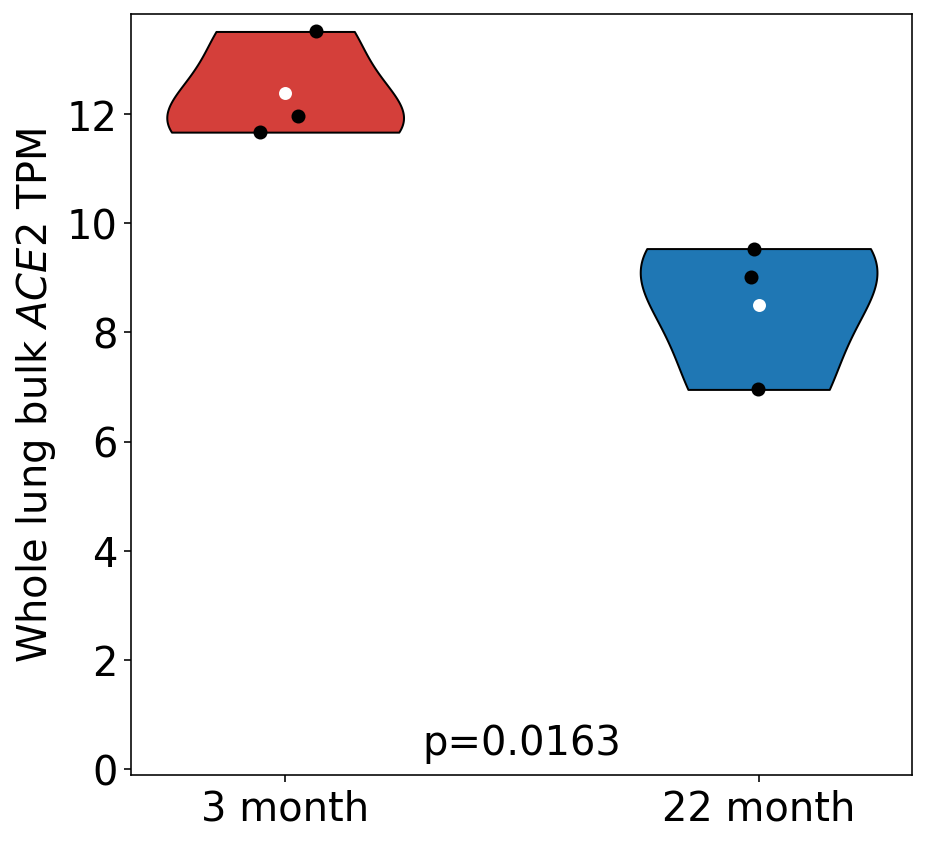

In [92]:
fig, ax = plt.subplots(figsize=(7,7))

gene = "ACE2"

labels = ['3 month', "22 month"]
lidx = [1, 2]


x = [young, old]

parts = ax.violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('#D43F3A')
    if pcidx==1: pc.set_facecolor('#1f77b4')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

    
mean = [np.mean(i) for i in x]
ax.scatter(lidx, mean, marker='o', color='white', s=30, zorder=3)


######## Add some random "jitter" to the x-axis
x = np.random.normal(1, 0.04, size=len(young))
ax.scatter(x, young, alpha=1, color="k")

x = np.random.normal(2, 0.04, size=len(old))
ax.scatter(x, old, alpha=1, color="k")

##########
ax.set_xticks(lidx)
ax.set_xticklabels(labels)



ax.annotate("p={:,.4f}".format(p), (1.5, ax.get_ylim()[1]*0.02), ha="center")

ax.set_ylim(-0.1)

ax.set_ylabel("Whole lung bulk $ACE2$ TPM")
plt.savefig("./figs/bulk_ace2.png", bbox_inches='tight',dpi=300)

plt.show()

In [93]:
young.mean()/old.mean()

1.4566345815724433

# TMPRS22

In [94]:
tmprss2 = df[df["gene_name"] == "Tmprss2"]

In [95]:
tmp = pd.DataFrame(tmprss2.groupby(["SRR", "gene_name"])["tpm"].sum()).reset_index()
tmp["age"] = tmp.SRR.map(age_map)

In [96]:
tmp

,SRR,gene_name,tpm,age
0,SRR8426373,Tmprss2,41.286521,22
1,SRR8426374,Tmprss2,46.281553,22
2,SRR8426375,Tmprss2,39.110920,22
3,SRR8426376,Tmprss2,47.914343,3
4,SRR8426377,Tmprss2,54.135463,3
5,SRR8426378,Tmprss2,46.573932,3


In [97]:
tmp.groupby("age")["tpm"].mean()

age
3     49.541246
22    42.226331
Name: tpm, dtype: float64

In [98]:
young = tmp[tmp.age==3]['tpm'].values
old = tmp[tmp.age==22]['tpm'].values
stat, p = stats.ttest_ind(young, old)

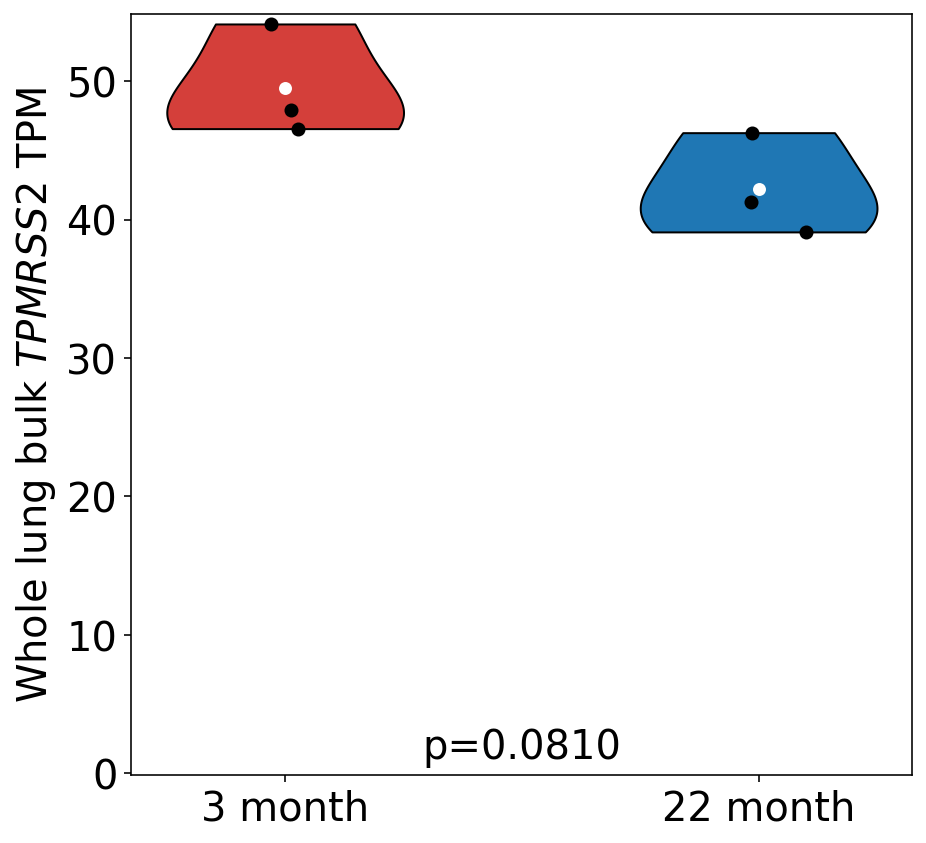

In [99]:
fig, ax = plt.subplots(figsize=(7,7))

gene = "ACE2"

labels = ['3 month', "22 month"]
lidx = [1, 2]


x = [young, old]

parts = ax.violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('#D43F3A')
    if pcidx==1: pc.set_facecolor('#1f77b4')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

    
mean = [np.mean(i) for i in x]
ax.scatter(lidx, mean, marker='o', color='white', s=30, zorder=3)


######## Add some random "jitter" to the x-axis
x = np.random.normal(1, 0.04, size=len(young))
ax.scatter(x, young, alpha=1, color="k")

x = np.random.normal(2, 0.04, size=len(old))
ax.scatter(x, old, alpha=1, color="k")

##########
ax.set_xticks(lidx)
ax.set_xticklabels(labels)



ax.annotate("p={:,.4f}".format(p), (1.5, ax.get_ylim()[1]*0.02), ha="center")

ax.set_ylim(-0.1)

ax.set_ylabel("Whole lung bulk $TPMRSS2$ TPM")
plt.savefig("./figs/bulk_tmprss2.png", bbox_inches='tight',dpi=300)

plt.show()

In [100]:
young.mean()/old.mean()

1.17323111806014